# Notebook to check the output from some test cases

(students are running into issues, let's see if I can reproduce)

In [1]:
import sys, os
import numpy as np
import mesa_reader as mr
import matplotlib.pyplot as plt 
import astropy.units as u
import astropy.constants as const


In [2]:
# Define a HR diagram plotting function that we can re-use
def HR_diagram(histoy_list, xlim=(None, None), ylim=(None, None),
               VMIN=-3, VMAX=0, cmap_name = 'rainbow', 
               colour_by='center_h1', colour_label='kleur',
               save_loc='./plots/'):
    """
    Plot a HR diagram from a list of mesa history data files.

    """

    fig, ax = plt.subplots(figsize=(10, 8))

    # Function to calc R from stefan-boltzmann law
    def Radius(Teff, L):
        Teff = Teff * u.K
        L = (L * u.Lsun).to(u.W)
        R = (L / (4 * np.pi * const.sigma_sb * Teff**4))**0.5
        return R.to(u.Rsun).value

    # --- Radius contour grid ---
    Teffs = np.linspace(3.5, 8, 100)
    Ls = np.linspace(2, 9.0, 100)
    Teffs_grid, Ls_grid = np.meshgrid(Teffs, Ls)
    Radius_grid = Radius(10**Teffs_grid, 10**Ls_grid)

    CS = ax.contour(Teffs_grid, Ls_grid, Radius_grid,
                    levels=[1, 10, 100, 1e3, 1e4],
                    colors='#969696', linestyles='dashed')
    ax.clabel(CS, inline=1, inline_spacing=-5, fontsize=15)
            #   manual=[(4.5, 3.2), (3.9, 3.2), (3.5, 3.2), (2.5, 3.2), (1.5, 3.1)])

    # --- Plot each star ---     
    for i, hist in enumerate(histoy_list):
        # find where to start the center h drops below 0.69
        start = np.flatnonzero(np.asarray(hist.center_h1) < 0.69)[0] if (np.asarray(hist.center_h1) < 0.69).any() else 0

        # get relevant data from the start of MS to 
        log_Teff = hist.log_Teff[start:] 
        log_L    = hist.log_L[start:] 
        C        = np.asarray(getattr(hist, colour_by))[start:]

        ax.plot(log_Teff, log_L, color = 'k', lw = 1)
        scat = ax.scatter(log_Teff, log_L, c=C, cmap = cmap_name, vmin=VMIN, vmax=VMAX, s=20, zorder =10)

        # Annotate the mass of the star at the start of the MS
        ax.scatter(log_Teff[0], log_L[0], marker='*', s=50)
        ax.text(log_Teff[0],  log_L[0] , f"${np.round(hist.star_mass[0], 1)}$"+"M$_{\odot}$",
                 ha='right', va='top', fontsize = 15) #log_Teff

    cb = plt.colorbar(scat, ax=ax)
    cb.set_label(colour_label if colour_label else (f"{colour_by} / L" if Lfrac else colour_by), fontsize=20)

    # -- Plot values -- 
    ax.set_xlabel('log$_{10}$(T$_{eff}$/K)', fontsize=25)
    ax.set_ylabel('log$_{10}$(L/L$_{\\odot}$)', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
    if xlim != (None, None): ax.set_xlim(xlim)
    if ylim != (None, None): ax.set_ylim(ylim)
    ax.invert_xaxis()
    fig.tight_layout()

    os.makedirs(save_loc, exist_ok=True)
    out = os.path.join(save_loc, f"HR_{colour_by}.png")
    plt.savefig(out, bbox_inches='tight')
    plt.show()
    return 


In [10]:
# print(donor_history.bulk_names)

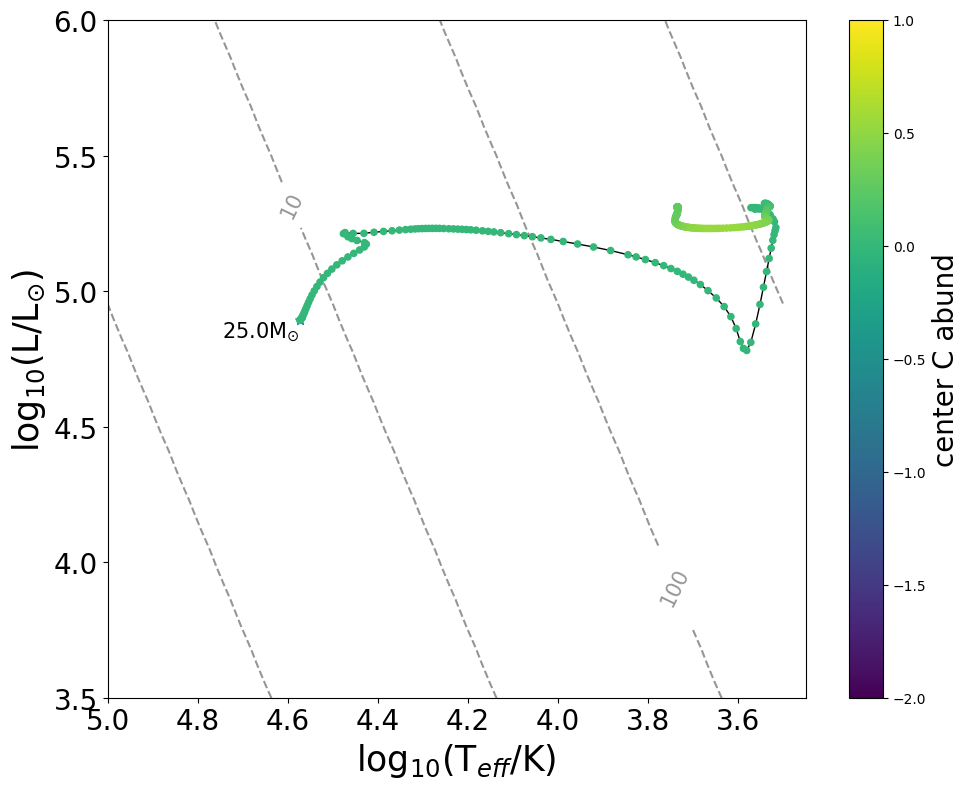

In [14]:
# Load your computed models
history           = mr.MesaData('./25M_z2m2_high_rotation/LOGS/history.data')

HR_diagram([history],
           xlim=(3.45, 5.), ylim=(3.5, 6.),
           VMIN=-2, VMAX=1, cmap_name = 'viridis',
           colour_by='center_c12', colour_label='center C abund')



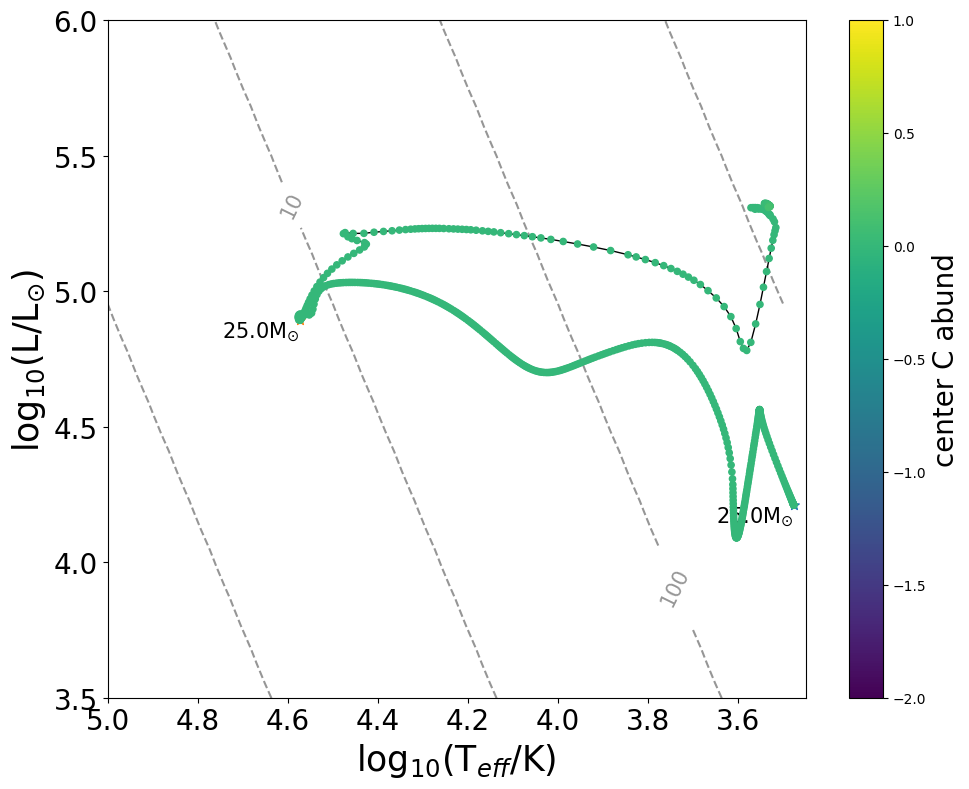

In [15]:
history_start           = mr.MesaData('./25M_z2m2_high_rotation/LOGS_start/history.data')
history_high_rot         = mr.MesaData('./25M_z2m2_high_rotation/LOGS_high_rot/history.data')

HR_diagram([history_start, history_high_rot],
           xlim=(3.45, 5.), ylim=(3.5, 6.),
           VMIN=-2, VMAX=1, cmap_name = 'viridis',
           colour_by='center_c12', colour_label='center C abund')


Text(0, 0.5, 'log10(abundance)')

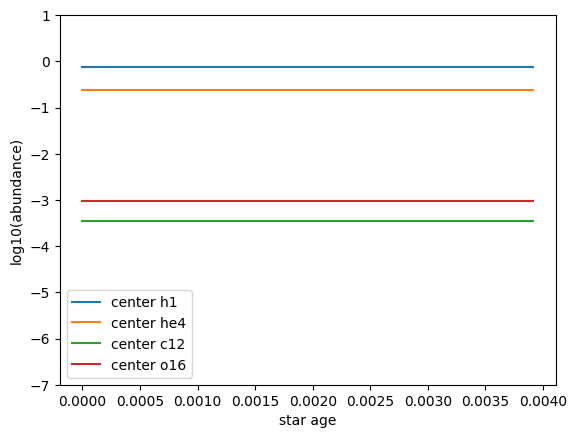

In [6]:
plt.plot(donor_history_lowerZ.star_age/10**6,  np.log10(donor_history_lowerZ.center_h1), label = 'center h1')
plt.plot(donor_history_lowerZ.star_age/10**6,  np.log10(donor_history_lowerZ.center_he4), label = 'center he4')
plt.plot(donor_history_lowerZ.star_age/10**6,  np.log10(donor_history_lowerZ.center_c12), label = 'center c12')
plt.plot(donor_history_lowerZ.star_age/10**6,  np.log10(donor_history_lowerZ.center_o16), label = 'center o16')

plt.legend()
plt.ylim(-7, 1)
plt.xlabel('star age')
plt.ylabel('log10(abundance)')